# Data Cube of transmissions : Fit with Gaussian Processes

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 7th 2027  
- update : January 10th 2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
import scipy
from scipy import interpolate

In [2]:
import os

In [3]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/users/dagoret/anaconda3/bin/python
3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel, ConstantKernel

In [5]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
#plt.rcParams['axes.formatter.useroffset']=  False

In [6]:
!ls data

20200211-holo-4-003-uniformity-datacube.npy


# Configuration

In [7]:
WL=np.arange(350,1200)
NWL=len(WL)

# Utility Functions

In [8]:
def get_list_of_position(arr):
    """
    Return the list of positions
    """
    
    
    ListOfPositions = [] 
    arrsize=len(arr)
    Npos=0
    
    for idx in np.arange(arrsize):
    
        currentposition = (arr[idx][1], arr[idx][2] )
    
        if currentposition not in ListOfPositions:
            ListOfPositions.append(currentposition)
            Npos+=1
            
            
    return Npos, ListOfPositions
    

In [9]:
def get_list_of_transmissions(arr):
    """
    
    """
    
    Narr=len(arr)
    Npos,list_of_position = get_list_of_position(arr)
    
    collectedtransmissions = np.empty(Npos, dtype=np.object)
    
    for idx in np.arange(Narr):   
        currentposition = (arr[idx][1], arr[idx][2])
        currentvalues = (arr[idx][3],arr[idx][4], arr[idx][5] )
  
    
        idx2=-1
        for position in list_of_position:
            idx2+=1
            
            if position == currentposition:
            
                if collectedtransmissions[idx2] == None:
                    collectedtransmissions[idx2] = []
                    collectedtransmissions[idx2].append(currentvalues)
                else:
                    collectedtransmissions[idx2].append(currentvalues)
                       
    
    return collectedtransmissions    
       

In [10]:
def find_nearest_point(list_of_points,x0=0,y0=0):
    
    N=len(list_of_points)
    distances = []
    
    for pos in list_of_points:
        dx=pos[0]-x0
        dy=pos[1]-y0
        distances.append(np.sqrt(dx**2 + dy**2))
    
    distances = np.array(distances)
    
    idx0 = np.where(distances == distances.min())[0][0]
    
    return idx0,distances[idx0]
    

In [11]:
def get_transmission_center(arr,x0=0,y0=0):
    """
    return the transmission of existing position (x0,y0) 
    
    """
    
    wl0 = np.array([], dtype=np.float64)
    eff0 = np.array([], dtype=np.float64)
    eeff0 = np.array([], dtype=np.float64)
    
    Npos,list_of_position = get_list_of_position(arr)
    arr_ext = get_list_of_transmissions(arr)
    
    idx0,d0=find_nearest_point(list_of_position,x0=x0,y0=y0)
     
    
    # loop on different positions
    for idx in np.arange(Npos):    
        list_of_datapoints = arr_ext[idx]
        x,y = list_of_position[idx]
    
        if idx==idx0:
            wl,eff,eeff = zip(*list_of_datapoints)   
            wl0 = wl
            eff0 = eff
            eeff0 =eeff          
        
    return wl0,eff0,eeff0
       

# Read Input file

In [12]:
datadir="data"
files_list= os.listdir(datadir)
print(files_list)
filename=files_list[0]
fullfilename=os.path.join(datadir,filename)
print(fullfilename)

['20200211-holo-4-003-uniformity-datacube.npy']
data/20200211-holo-4-003-uniformity-datacube.npy


In [13]:
arr=np.load(fullfilename)

In [14]:
arr.shape

(3443,)

In [15]:
NARR=arr.shape[0]

In [16]:
arr

array([(0,  0.,  0., 400.014, 0.28404813, 7.02226350e-04),
       (0,  0.,  0., 419.989, 0.09057611, 2.22853061e-04),
       (0,  0.,  0., 440.023, 0.02899506, 5.77351450e-05), ...,
       (2, -4., -4., 519.984, 0.06957727, 9.21319092e-05),
       (2, -4., -4., 540.001, 0.05970568, 7.87463120e-05),
       (2, -4., -4., 559.997, 0.03172864, 4.54447038e-05)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [17]:
order0 = arr["order"]== 0
order1 = arr["order"]== 1
order2 = arr["order"]== 2

In [18]:
arr_0 = arr[order0]
arr_1 = arr[order1]
arr_2 = arr[order2]

# Order 1

## List of positions

In [19]:
Npos1,list_of_position_1 = get_list_of_position(arr_1)

In [20]:
Npos1

48

In [21]:
print(list_of_position_1)

[(0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 4.0), (0.0, -1.0), (0.0, -2.0), (0.0, -4.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (1.0, 4.0), (1.0, -1.0), (1.0, -2.0), (1.0, -4.0), (2.0, 0.0), (2.0, 1.0), (2.0, 2.0), (2.0, 4.0), (2.0, -1.0), (2.0, -2.0), (2.0, -4.0), (4.0, 0.0), (4.0, 1.0), (4.0, 2.0), (4.0, 4.0), (4.0, -1.0), (4.0, -2.0), (-1.0, 0.0), (-1.0, 1.0), (-1.0, 2.0), (-1.0, 4.0), (-1.0, -1.0), (-1.0, -2.0), (-1.0, -4.0), (-2.0, 0.0), (-2.0, 1.0), (-2.0, 2.0), (-2.0, 4.0), (-2.0, -1.0), (-2.0, -2.0), (-2.0, -4.0), (-4.0, 0.0), (-4.0, 1.0), (-4.0, 2.0), (-4.0, 4.0), (-4.0, -1.0), (-4.0, -2.0), (-4.0, -4.0)]


In [22]:
len(list_of_position_1)

48

## Find the list of different positions

In [23]:
arr_1_ext = get_list_of_transmissions(arr_1)

<ipython-input-9-466b74409715>:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  collectedtransmissions = np.empty(Npos, dtype=np.object)


In [24]:
len(arr_1_ext)

48

## Plot transmissions

In [25]:
from matplotlib import cm, colors
values = np.linspace(-4.0, 4.0, 10)
norm = colors.Normalize(vmin=-4.0, vmax=4.0, clip=False)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
for value in values:
   print("%.2f" % value, "=",
      "red:%.2f" % mapper.to_rgba(value)[0],
      "green:%.2f" % mapper.to_rgba(value)[1],
      "blue:%.2f" % mapper.to_rgba(value)[2])

-4.00 = red:0.00 green:0.00 blue:1.00
-3.11 = red:0.22 green:0.22 blue:1.00
-2.22 = red:0.44 green:0.44 blue:1.00
-1.33 = red:0.67 green:0.67 blue:1.00
-0.44 = red:0.89 green:0.89 blue:1.00
0.44 = red:1.00 green:0.89 blue:0.89
1.33 = red:1.00 green:0.67 blue:0.67
2.22 = red:1.00 green:0.44 blue:0.44
3.11 = red:1.00 green:0.22 blue:0.22
4.00 = red:1.00 green:0.00 blue:0.00


Text(0.5, 0.98, 'Transmission for Order 1')

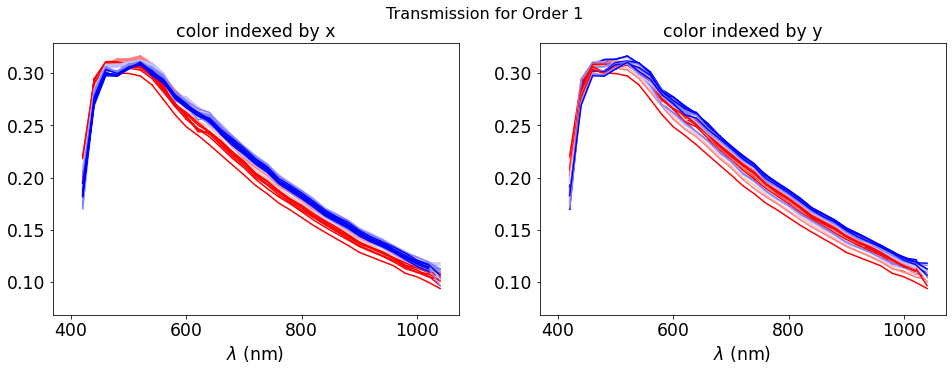

In [26]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    if x==0 and y==0:
        wl0 = wl
        eff0 = eff
        f0 = interpolate.interp1d(wl0, eff0,kind='cubic')
    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    
plt.suptitle("Transmission for Order 1",fontsize=16)  

Text(0.5, 0.98, 'Transmission ratio for Order 1')

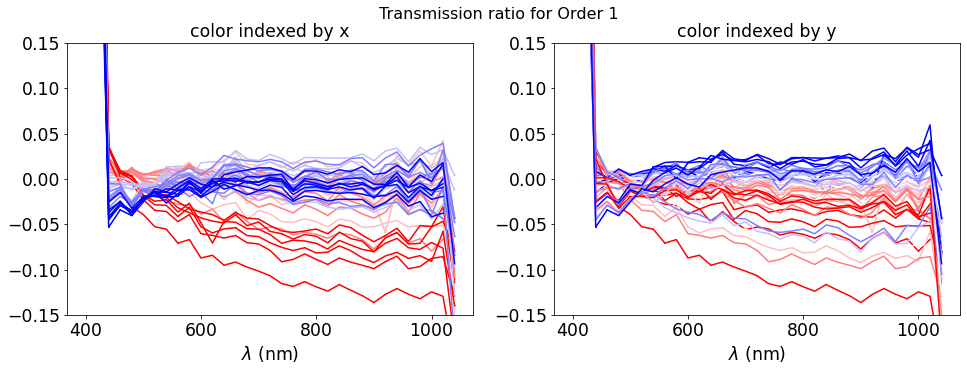

In [27]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    
        
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints) 
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl)-1 
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl) -1
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
    
plt.suptitle("Transmission ratio for Order 1",fontsize=16)  

# Fit with Gaussian Process

## Fit 1D Gaussian Process

In [28]:
idx_sel = 0

In [29]:
list_of_datapoints = arr_1_ext[idx_sel]
x,y = list_of_position_1[idx_sel]
wl,eff,eeff = zip(*list_of_datapoints)  

In [30]:
wl=np.array(wl)
eff=np.array(eff)
eeff=np.array(eeff)

In [31]:
N=len(wl)

<ErrorbarContainer object of 3 artists>

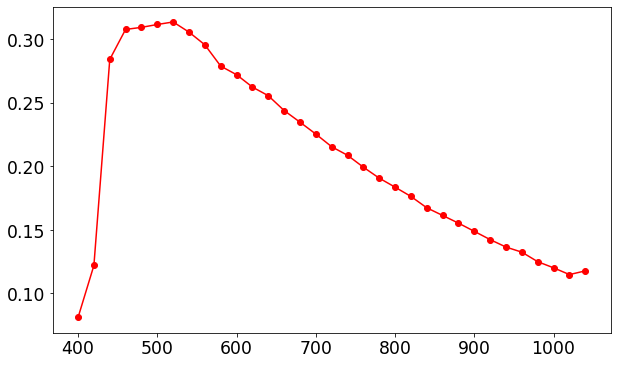

In [32]:
plt.errorbar(wl,eff,yerr=eeff,marker="o",ecolor="grey",color="r")

### utility functions

In [33]:
def fitGPTransmission(wl,eff,efferr,errorfactor=1):
    
    wl=np.array(wl)
    eff=np.array(eff)
    eeff=np.array(efferr)*errorfactor
    
    N=len(wl)
    
    kernel = 1 * RBF(length_scale=10.0, length_scale_bounds=(1e-1, 1e3))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=eeff ** 2, n_restarts_optimizer=9)
    
    X_train = wl.reshape((N,1))
    y_train = eff
    
    X = WL.reshape((NWL,1))
    gaussian_process.fit(X_train, y_train)
    
    #print(gaussian_process.kernel_)
    
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    return mean_prediction, std_prediction, gaussian_process.kernel_

In [34]:
def plotfitGPTransmission(wl,eff,efferr,errorfactor=1,ax=None):
    
    mean_prediction, std_prediction, kparams  = fitGPTransmission(wl,eff,efferr,errorfactor=errorfactor)
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        
    ax.errorbar(wl,eff,yerr=eeff,marker="o",ecolor="k",color="r",label="Observations")
    ax.plot(WL, mean_prediction, label="Mean prediction")
    ax.fill_between(
        WL,
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",color="cyan"
    )
    ax.legend()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("transmission efficiency")
    ax.set_title(f"GP regression on efficiency at position {idx_sel} : (x,y) = ({x},{y})")
    
    

### 1D fit on the selected point

In [35]:
mean_prediction, std_prediction, k =  fitGPTransmission(wl,eff,eeff,errorfactor=1)

In [36]:
k.get_params()

{'k1': 0.165**2,
 'k2': RBF(length_scale=29.9),
 'k1__constant_value': 0.027172217047237827,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 29.868818445170966,
 'k2__length_scale_bounds': (0.1, 1000.0)}

In [37]:
k.get_params()['k2__length_scale']

29.868818445170966

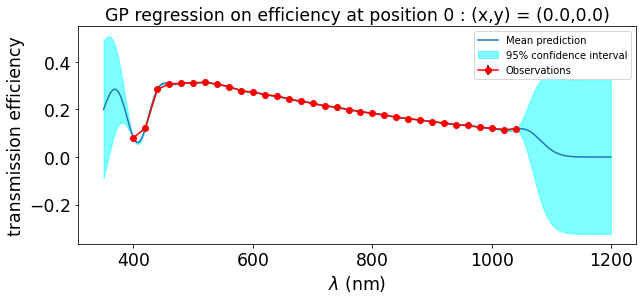

In [38]:
plotfitGPTransmission(wl,eff,eeff,errorfactor=1,ax=None)

### Loop on all points to fit a 1D gaussian process

<ipython-input-34-28565a8ce830>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,4))
/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


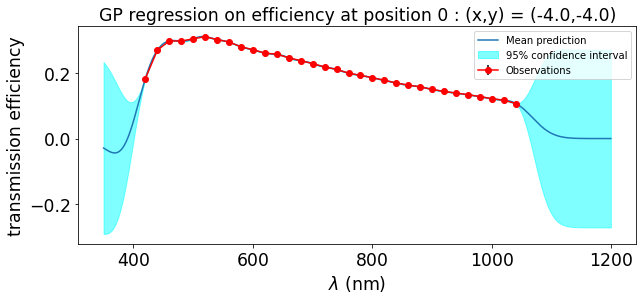

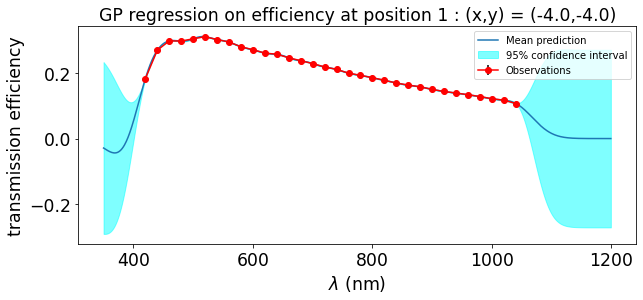

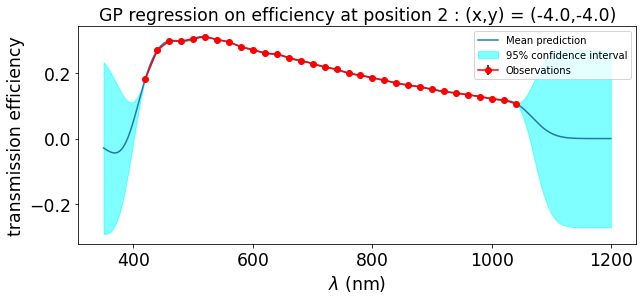

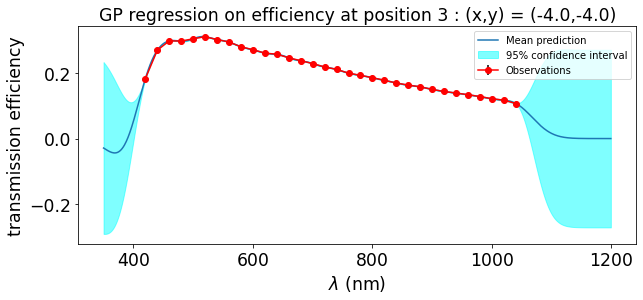

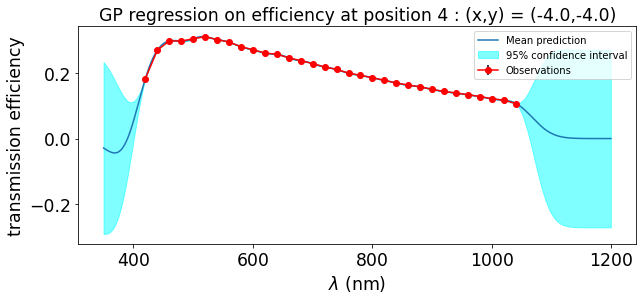

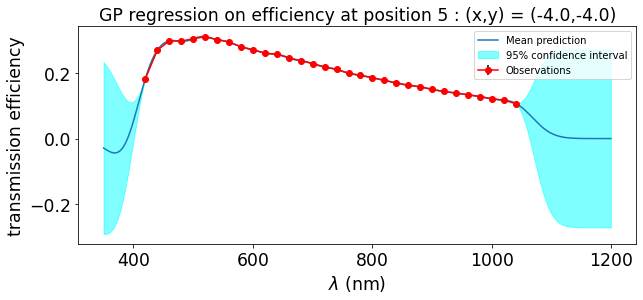

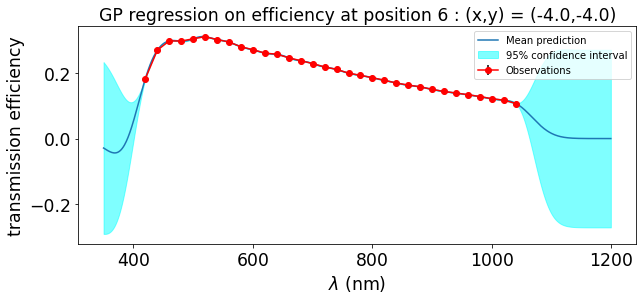

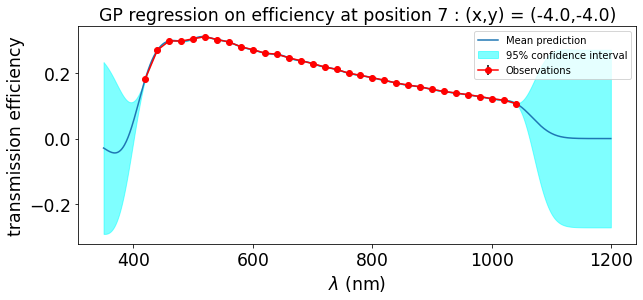

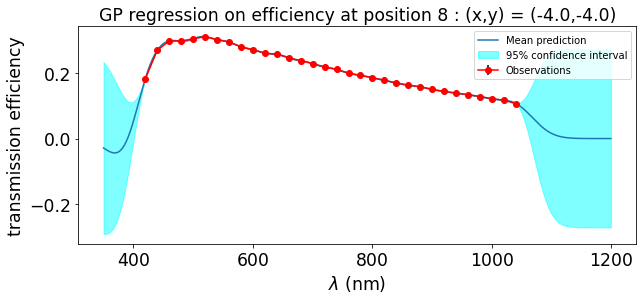

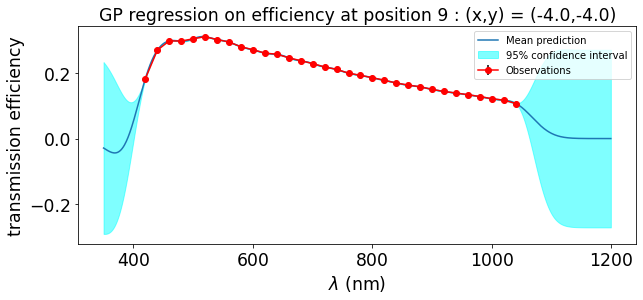

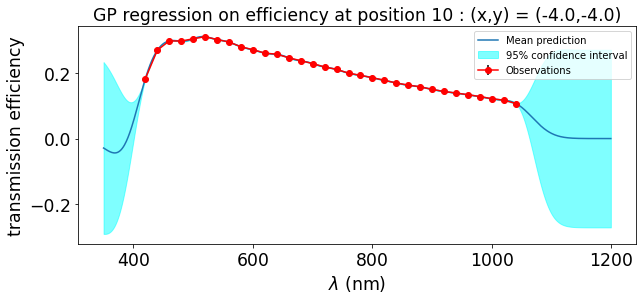

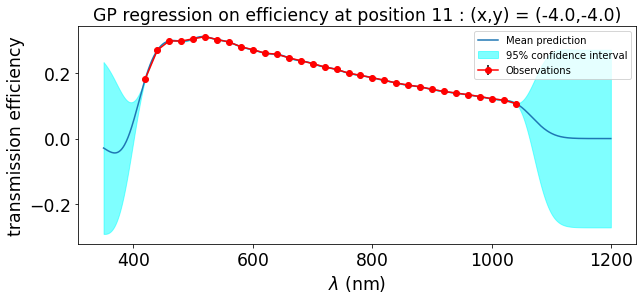

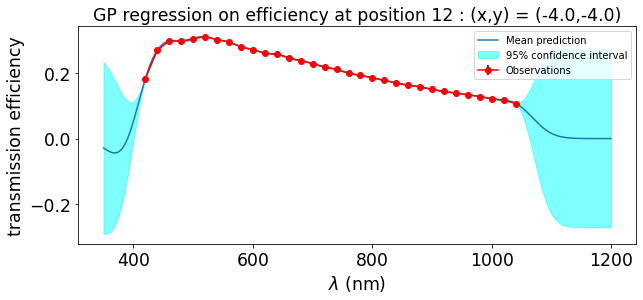

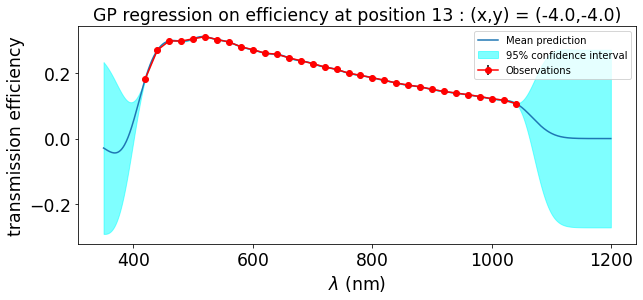

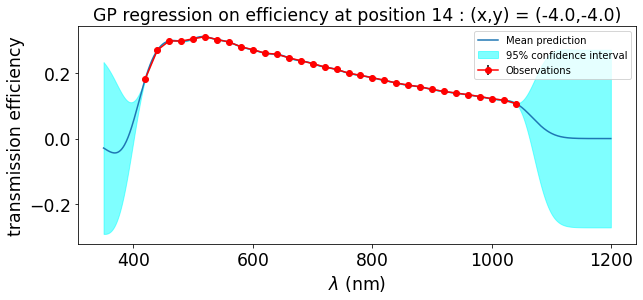

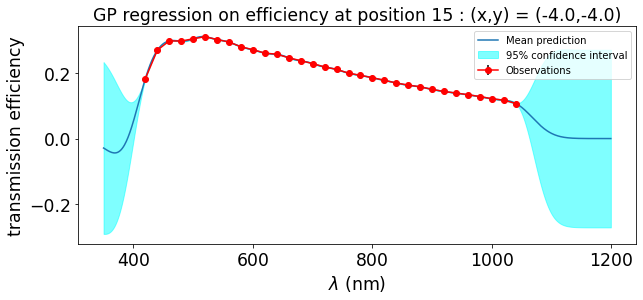

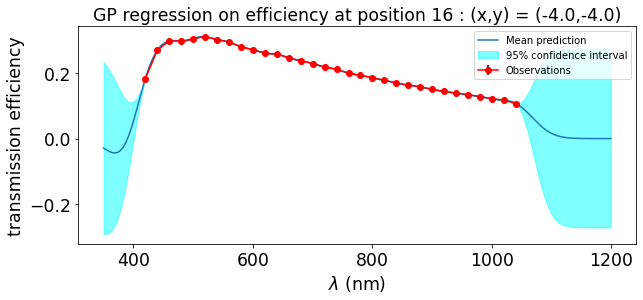

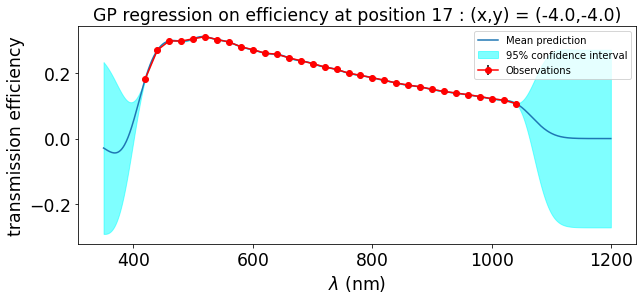

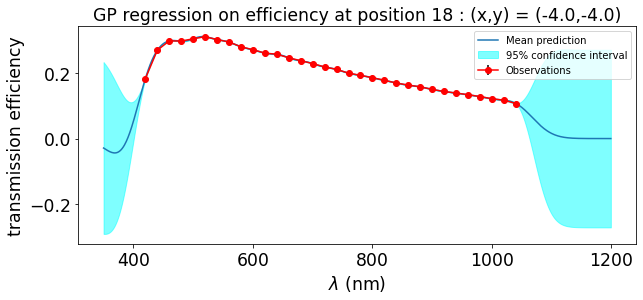

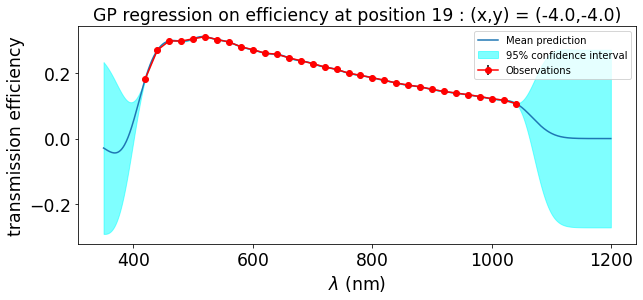

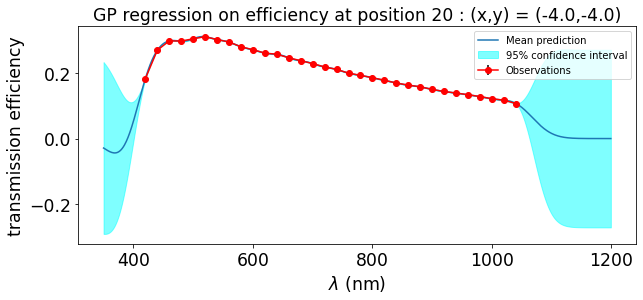

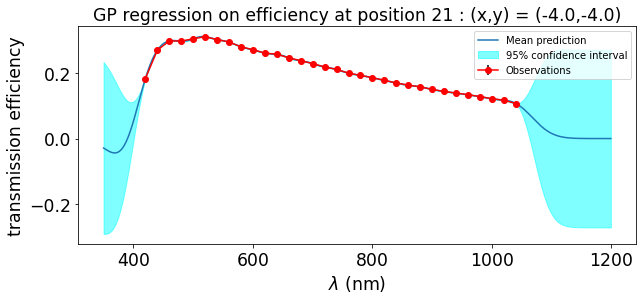

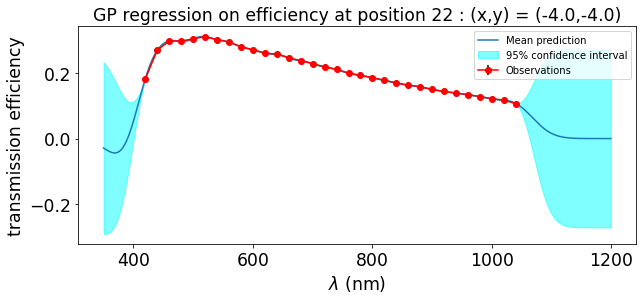

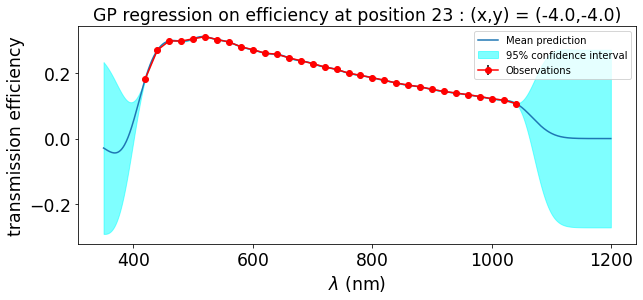

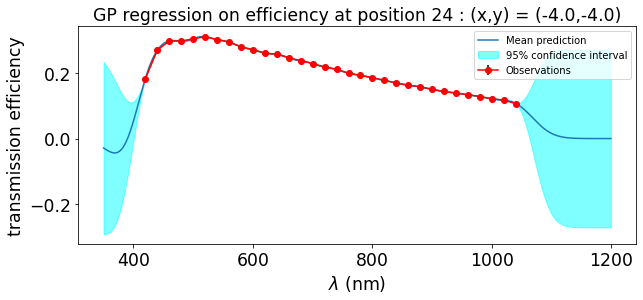

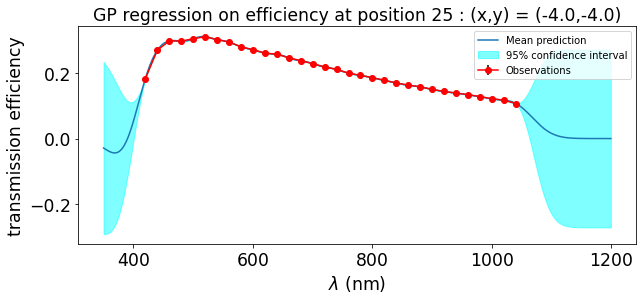

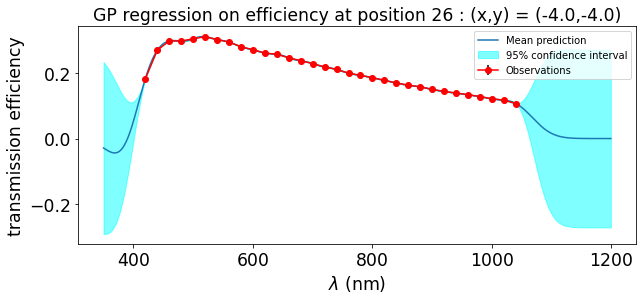

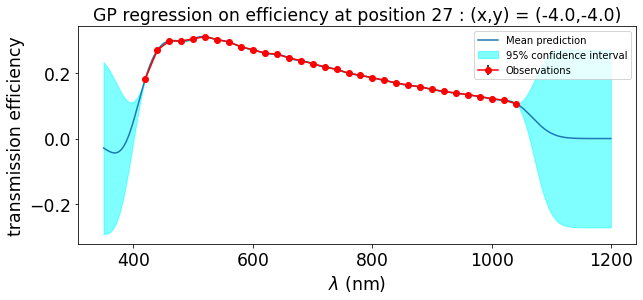

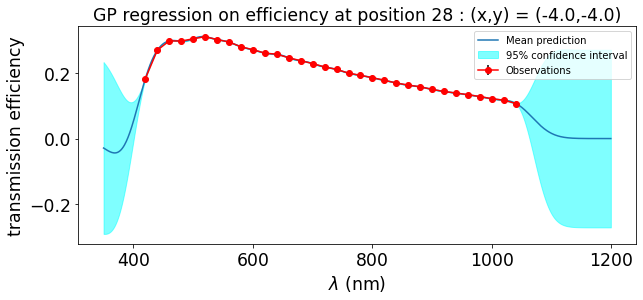

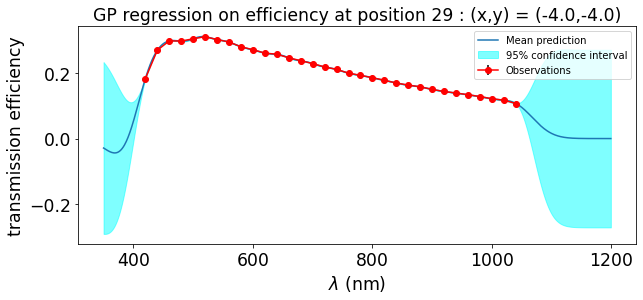

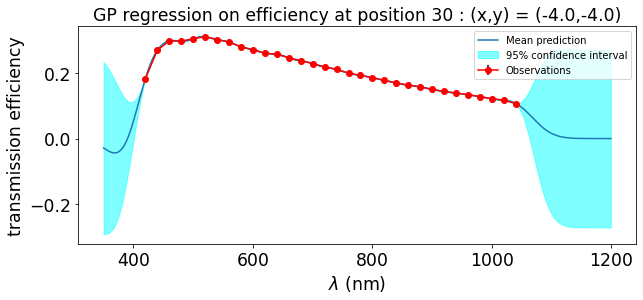

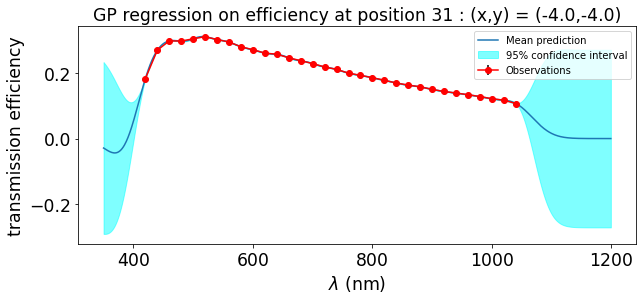

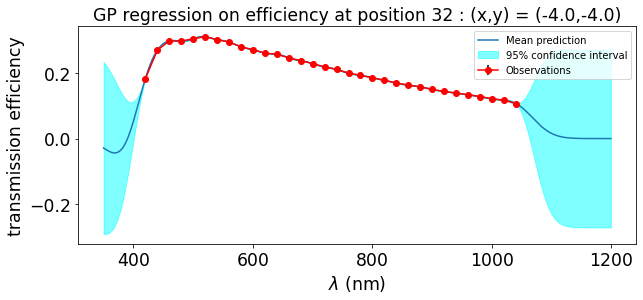

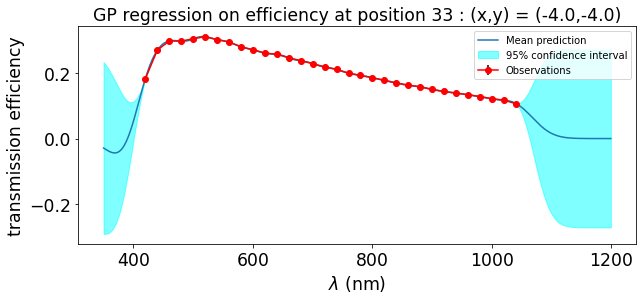

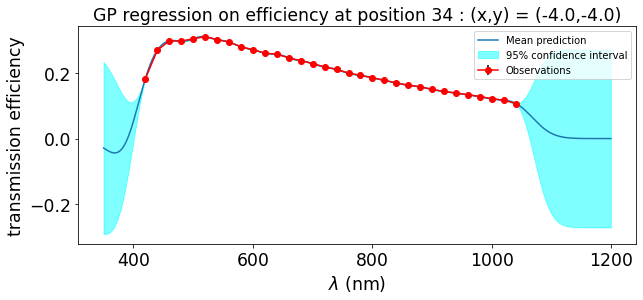

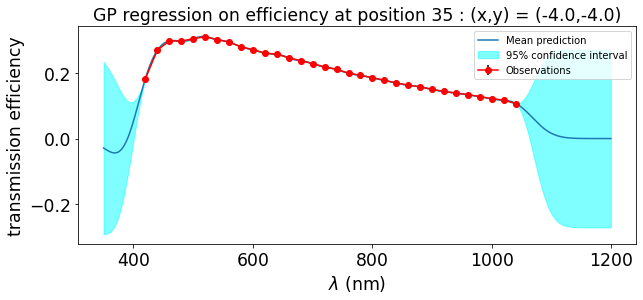

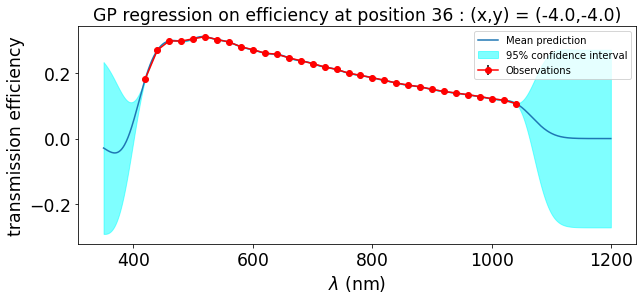

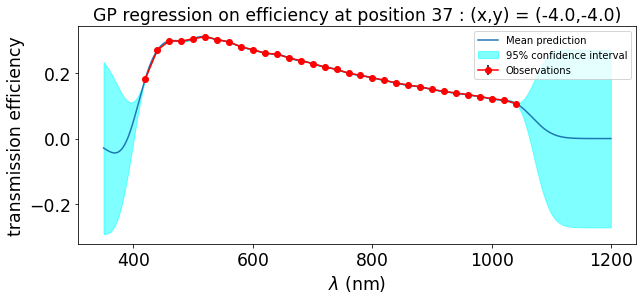

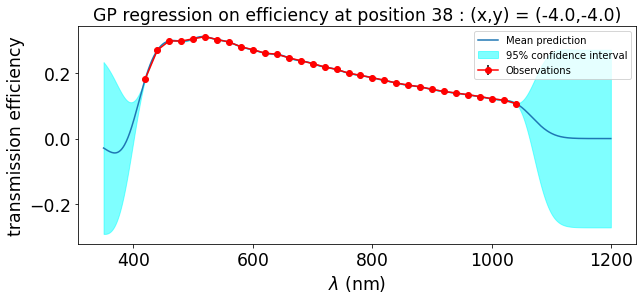

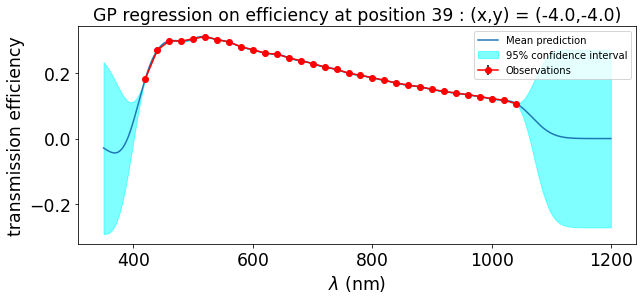

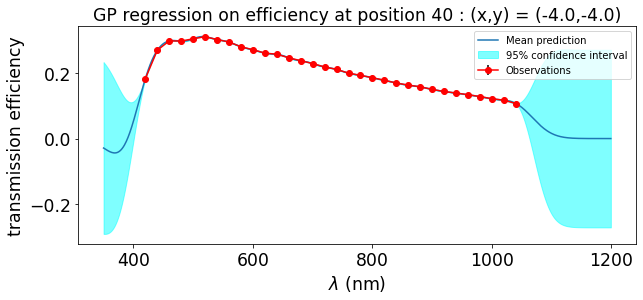

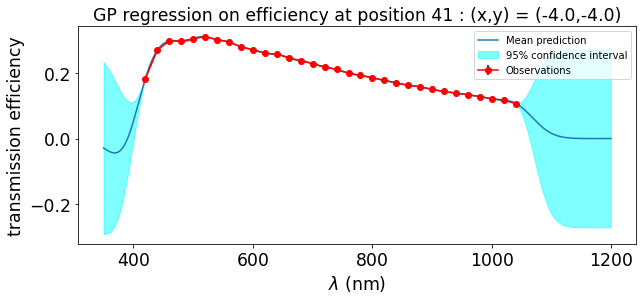

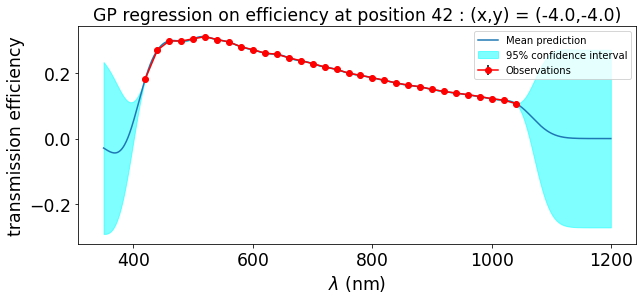

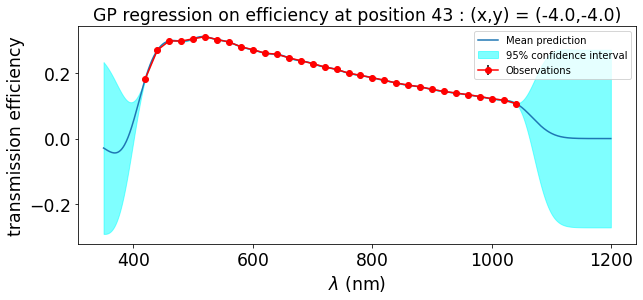

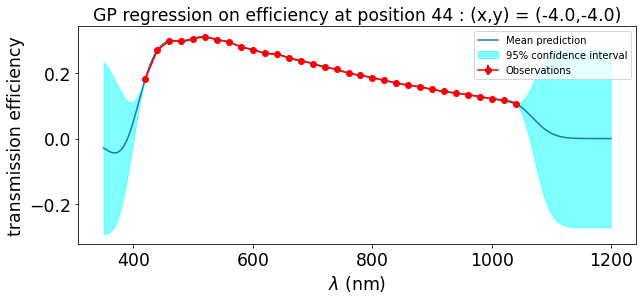

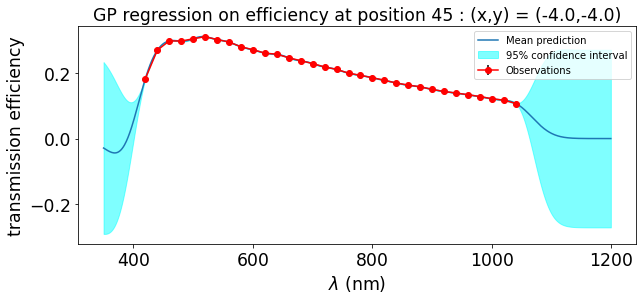

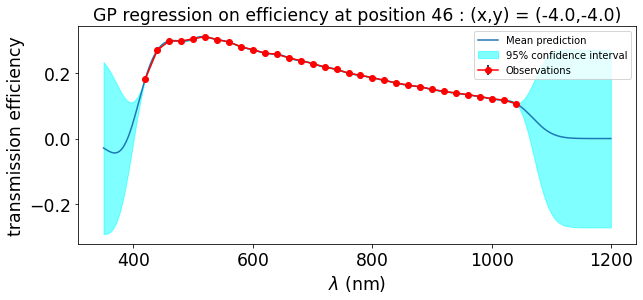

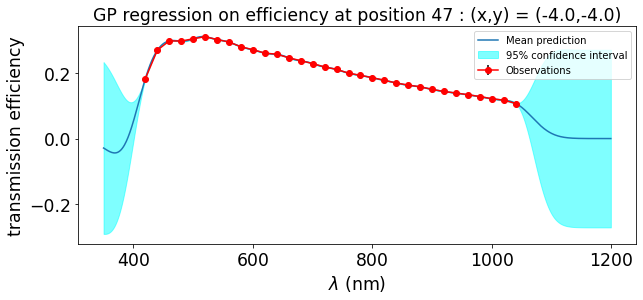

In [39]:
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    wl,eff,eeff = zip(*list_of_datapoints)  
    plotfitGPTransmission(wl,eff,eeff,errorfactor=1,ax=None)
    

### Loop on all examples to find the hyper - parameters of the kernel

In [40]:
all_k1 = np.zeros(Npos1)
all_k2 = np.zeros(Npos1)
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    
    mean_prediction, std_prediction, k  = fitGPTransmission(wl,eff,eeff,errorfactor=1)
    
    k1 = k.get_params()['k1__constant_value']
    k2 = k.get_params()['k2__length_scale']
    all_k1[idx_sel] = k1
    all_k2[idx_sel] = k2

/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [41]:
all_k1

array([0.01905443, 0.01905443, 0.01905443, 0.01905443, 0.01905443,
       0.01905443, 0.01905443, 0.01905443, 0.01905444, 0.01905443,
       0.01905443, 0.01905443, 0.01905443, 0.01905443, 0.01905443,
       0.01905443, 0.01905443, 0.01905443, 0.01905445, 0.01905443,
       0.01905445, 0.01905443, 0.01905443, 0.01905443, 0.01905443,
       0.01905443, 0.01905442, 0.01905443, 0.01905441, 0.01905443,
       0.01905443, 0.01905443, 0.01905444, 0.01905443, 0.01905443,
       0.01905443, 0.01905443, 0.01905443, 0.01905443, 0.01905443,
       0.01905443, 0.01905443, 0.01905443, 0.01905443, 0.01905443,
       0.01905443, 0.01905443, 0.01905443])

In [42]:
all_k2

array([33.03412447, 33.03412591, 33.03412447, 33.03412586, 33.03412593,
       33.03412586, 33.03412593, 33.03412631, 33.0341262 , 33.0341259 ,
       33.0341253 , 33.0341262 , 33.03412586, 33.03412586, 33.03412586,
       33.03412586, 33.03412586, 33.03412619, 33.03412567, 33.03412586,
       33.03412911, 33.03412586, 33.03412584, 33.03412586, 33.03412476,
       33.03412591, 33.03412429, 33.03412586, 33.03412912, 33.03412542,
       33.03412586, 33.03412592, 33.03412621, 33.03412586, 33.03412586,
       33.03412586, 33.03412595, 33.03412586, 33.0341265 , 33.03412597,
       33.0341259 , 33.03412586, 33.03412586, 33.03412586, 33.0341263 ,
       33.03412586, 33.03412586, 33.03412586])

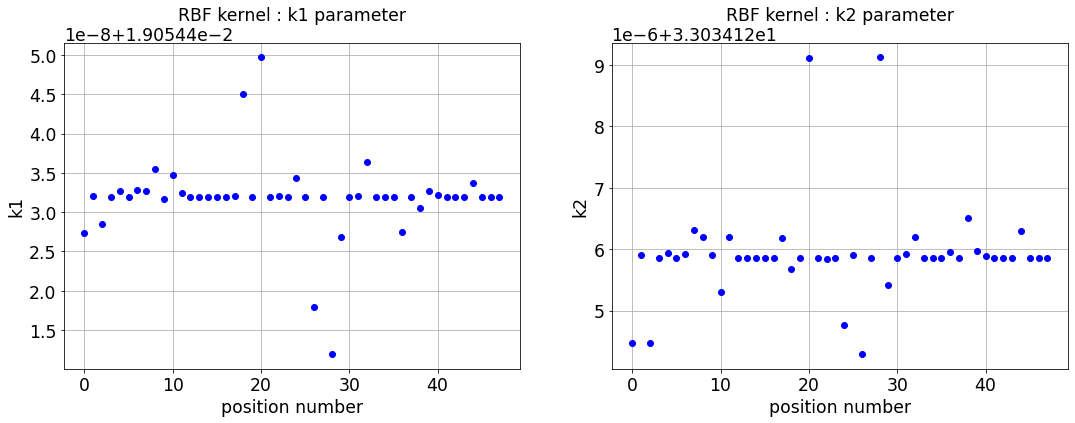

In [43]:
fig = plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,2,1)
ax.plot(all_k1,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k1")
ax.set_title("RBF kernel : k1 parameter",y=1.05)
ax.grid()
ax=fig.add_subplot(1,2,2)
ax.plot(all_k2,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k2")
ax.set_title("RBF kernel : k2 parameter",y=1.05)
ax.grid()

In [44]:
assert False

AssertionError: 

## Fit 3D Gaussian Process

### create data arrays

In [45]:
arr_1

array([(1,  0.,  0.,  400.014, 0.08113432, 0.00042531),
       (1,  0.,  0.,  419.989, 0.12204722, 0.00055285),
       (1,  0.,  0.,  440.023, 0.28427847, 0.0003543 ), ...,
       (1, -4., -4.,  999.966, 0.12115345, 0.00016043),
       (1, -4., -4., 1019.98 , 0.11694063, 0.00014926),
       (1, -4., -4., 1040.023, 0.10674954, 0.00015927)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [46]:
arr=arr_1
Narr = len(arr)
X = np.zeros((Narr,3))
Y = np.zeros(Narr)
EY = np.zeros(Narr)
for idx in np.arange(Narr):    

    X[idx,0]=arr[idx][1]
    X[idx,1]=arr[idx][2]
    X[idx,2]=arr[idx][3]
    
    Y[idx]=arr[idx][4]
    EY[idx] = arr[idx][5]

In [ ]:
X

In [ ]:
Y

In [ ]:
EY

In [48]:
kernel = RBF(length_scale=(0.5,0.5,33.0),length_scale_bounds =  (1e-2,1e3))

In [49]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=Ey ** 2, n_restarts_optimizer=9)

NameError: name 'Ey' is not defined

In [ ]:
gpr = gaussian_process.fit(X, Y)